In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.is_available()

False

In [3]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100,shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100,shuffle=False)

In [4]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

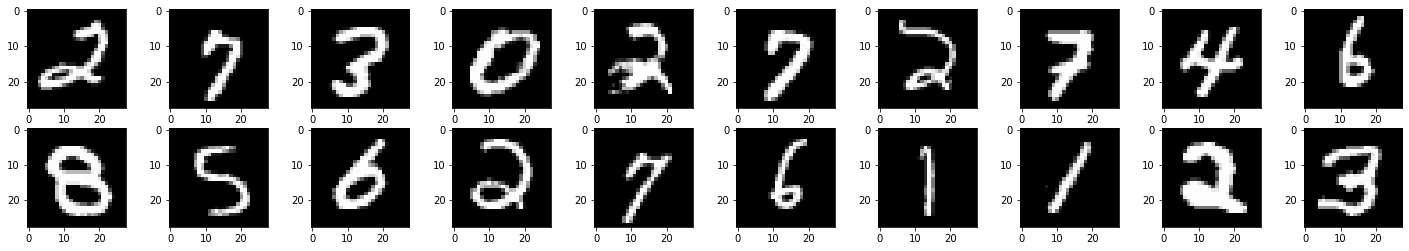

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    fig.add_subplot(2, 10, idx+1)
    plt.imshow(im_convert(images[idx]))

In [16]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(800, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [17]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
epochs = 1
running_loss_history = []
running_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
for e in range (epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,  1)
        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels) 
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        
        running_loss_history.append(epoch_loss)
        running_accuracy_history.append(epoch_acc)
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader) 
        val_loss_history.append(val_epoch_loss)
        val_accuracy_history.append(val_epoch_acc)
        print('epoch: ', e + 1)
        print("training loss: {:.4f}, accuracy: {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, accuracy: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

KeyboardInterrupt: 

In [ ]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_loss_history, label="validation loss")
plt.legend()

In [ ]:
plt.plot(running_accuracy_history, label="training accuracy")
plt.plot(val_accuracy_history, label="validation accuracy")
plt.legend()

In [ ]:
import requests
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

In [ ]:
import PIL.ImageOps
img = PIL.ImageOps.invert(img.convert('RGB'))
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [15]:
img = img.to(device)
print(ig[0])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 20 1 5 5, but got 3-dimensional input of size [1, 28, 28] instead

dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx] == labels[idx] else "red"))